# Perfs

## Import de la recherche

In [1]:
from typing import Callable, List, Dict
from index import Document, Corpus, InvertedIndex, Query

import pandas, os, re

DATA_FOLDER = os.path.join(os.getcwd(), "output")
INDEX_OUTPUT_DIR = os.path.join(DATA_FOLDER, "index_files")

XML_INITIAL_FILE = os.path.join(DATA_FOLDER, "corpus_initial.xml")
STEMMED_REPLACEMENTS = os.path.join(DATA_FOLDER, "stemmed_replacement.tsv")
LEMMATIZED_REPLACEMENTS = os.path.join(DATA_FOLDER, "lemmatized_replacement.tsv")

STORAGE_TAGS = {"Corpus": "corpus", "documents": "bulletins", "Document": "bulletin", "Image": "image"}

### Reconstruction des Index

In [2]:
# 1. Charge le Corpus
with open(XML_INITIAL_FILE, "r", encoding="utf-8") as f:
    CORPUS = Corpus.model_validate_xml(f.read(), tags=STORAGE_TAGS)

# 2. Charge l'Index inversé par zone et par type de tokenisation
INDEXES: Dict[str, Dict[str, InvertedIndex]] = {}
for index_type in ["lemmatized", "stemmed"]:
    INDEXES[index_type] = {}
    for zone in ["texte", "legendes", "titre"]:
        INDEXES[index_type][zone] = InvertedIndex.from_dataframe(pandas.read_csv(os.path.join(INDEX_OUTPUT_DIR, f"index_{zone}_{index_type}.xml"), sep="\t", encoding="utf-8"))

C:\Users\ongki\AppData\Local\Temp\ipykernel_6300\2807305975.py:10: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,25

### Chargement des fichiers de substitutions pour le processing des mots clés

In [3]:
lemma_substitutions = pandas.read_csv(LEMMATIZED_REPLACEMENTS, sep="\t", encoding="utf-8", index_col=0, header=None).to_dict()[1]
stem_substitutions = pandas.read_csv(STEMMED_REPLACEMENTS, sep="\t", encoding="utf-8", index_col=0, header=None).to_dict()[1]

### Fonctions d'evaluation

In [28]:
STANDARDIZE: Callable[[str], str] = lambda x: re.sub(r"[^\w\s]", "", re.sub(r"'", " ", x.strip().lower()))
TOKENIZE_LEMMATIZE: Callable[[List[str]], List[str]] = lambda x: lemma_substitutions.get(STANDARDIZE(x), STANDARDIZE(x))
TOKENIZE_STEM: Callable[[List[str]], List[str]] = lambda x: stem_substitutions.get(STANDARDIZE(x), STANDARDIZE(x))

def APPLY(q: Query, func: callable, fields: List[str]) -> Query:
    """Apply a function to the tokens in specified fields of a Query object."""
    for field in fields:
        setattr(q, field, [func(token) for token in getattr(q, field)] if isinstance(getattr(q, field), list) else func(getattr(q, field)))
    return q

def recherche_lemma_ia(query: str) -> List[Document]:
    q = Query.llm_build(query)
    APPLY(q, TOKENIZE_LEMMATIZE, ["keywords", "excluded_keywords", "title_contains"])
    APPLY(q, STANDARDIZE, ["rubriques", "excluded_rubriques"])
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["lemmatized"])

def recherche_stem_ia(query: str) -> List[Document]:
    q = Query.llm_build(query)
    APPLY(q, TOKENIZE_LEMMATIZE, ["keywords", "excluded_keywords", "title_contains"])
    APPLY(q, STANDARDIZE, ["rubriques", "excluded_rubriques"])
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["stemmed"])

def recherche_lemma_regex(query: str) -> List[Document]:
    q = Query.build(query)
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["lemmatized"])

def recherche_stem_regex(query: str) -> List[Document]:
    q = Query.build(query)
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["stemmed"])

In [5]:
Query.llm_build("Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les Etats-Unis ?")

Query(keywords=['Etats-Unis'], keywords_operator='AND', rubriques=[], excluded_keywords=[], excluded_rubriques=[], date_start=datetime.datetime(2013, 3, 3, 0, 0, tzinfo=TzInfo(UTC)), date_end=datetime.datetime(2013, 5, 4, 0, 0, tzinfo=TzInfo(UTC)), excluded_date_periods=[], title_contains=[], has_image=False, target_info='articles')

In [30]:
res = recherche_lemma_ia("montre moi les articles qui parlent de environnement, minimum depuis juillet 2011 et qui nest pas dans la rubrique Focus")
res[0] if res else []

Document(fichier='73875.htm', numero='284', date=datetime.datetime(2013, 9, 10, 0, 0), rubrique='Focus', titre='Ingénierie de la construction : Ingérop fête ses cinquante ans', auteur='ADIT - Jean-François Desessard - email : jfd@adit.fr', contact='Ingérop - Silvia Nimo : tél. : +33 (0)1 49 04 55 08 email : silvia.nimo@ingerop.com - http://www.ingerop.fr', texte='En juin dernier, le Français Ingérop a fêté ses cinquante ans. Pour l\'occasion, cette société d\'ingénierie de la construction, ancienne filiale de GTM, mais détenue depuis le début des années 2000 par ses cadres, près de 300 à ce jour, ce qui est une particularité, avait choisi de donner rendez-vous à ses clients dans les jardins du Musée Rodin à Paris, associant ainsi le temps d\'une soirée quelques-unes des oeuvres de celui qui a révolutionné la sculpture à la fin du XIXème siècle à quelques-uns des projets les plus marquants de l\'histoire de l\'ingénieriste. Son Président, Yves Metz, qui venait, dans l\'après-midi, de si

## Evaluation des Performances

In [35]:
TRUTH: Dict[str, List[Document]] = {
    "Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les Etats-Unis ?": ["72932.htm"],
    "Je veux les articles de 2014 et de la rubrique Focus et parlant de la santé": ["75458.htm", "75459.htm", "76507.htm"],
    "Je souhaite les rubriques des articles parlant de nutrition ou de vins.": ["Focus", "Au coeur des régions", "Du côté des pôles", "Actualité Innovation", "A lire"], 
}

### Calcul des métriques

In [36]:
import pandas, datetime

CASES = ["ia_lemma", "ia_stem", "reg_lemma", "reg_stem"]
EVALUATORS = [recherche_lemma_ia, recherche_stem_ia, recherche_lemma_regex, recherche_stem_regex]

DATA: Dict[str, pandas.DataFrame] = {name: pandas.DataFrame(columns=["Recall", "Precision", "Delay", "Hint"]) for name in CASES}
for layer, search in zip(CASES, EVALUATORS):

    for query, truth in TRUTH.items():
        
        start = datetime.datetime.now()
        results = [d.document_id for d in search(query)]

        row = {
            "Recall":    len(set(results) & set(truth)) / len(truth),
            "Precision": len(set(results) & set(truth)) / len(results) if len(results) > 0 else 0.0,
            "Size":      len(results),
            "Delay":     (datetime.datetime.now() - start).total_seconds(),
            "Hint":      query,
        }

        DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)

DATA["ia_lemma"]

C:\Users\ongki\AppData\Local\Temp\ipykernel_6300\3796103231.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)
C:\Users\ongki\AppData\Local\Temp\ipykernel_6300\3796103231.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)
C:\Users\ongki\AppData\Local\Temp\ipykernel_6300\3796103231.py:23: FutureWarning: The behavior of Da

,Recall,Precision,Delay,Hint,Size
0,0.0,0.0,4.918042,Quels sont les articles parus entre le 3 mars ...,0.0
1,1.0,1.0,2.778075,Je veux les articles de 2014 et de la rubrique...,3.0
2,0.0,0.0,2.134162,Je souhaite les rubriques des articles parlant...,24.0


In [37]:
DATA["ia_stem"]

,Recall,Precision,Delay,Hint,Size
0,0.0,0.0,2.677434,Quels sont les articles parus entre le 3 mars ...,0.0
1,0.0,0.0,2.501852,Je veux les articles de 2014 et de la rubrique...,0.0
2,0.0,0.0,2.111848,Je souhaite les rubriques des articles parlant...,8.0


### Visualisation

In [40]:
df = pandas.DataFrame(columns=["Delay", "Recall", "Precision", "Model"])
for model, data in DATA.items():
    df = pandas.concat([
        df,
        data[["Delay", "Recall", "Precision"]].assign(Model=model)
    ], ignore_index=True)
df.head(2)

C:\Users\ongki\AppData\Local\Temp\ipykernel_6300\618777212.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pandas.concat([


,Delay,Recall,Precision,Model
0,4.918042,0.0,0.0,ia_lemma
1,2.778075,1.0,1.0,ia_lemma


<Axes: xlabel='Model', ylabel='Delay'>

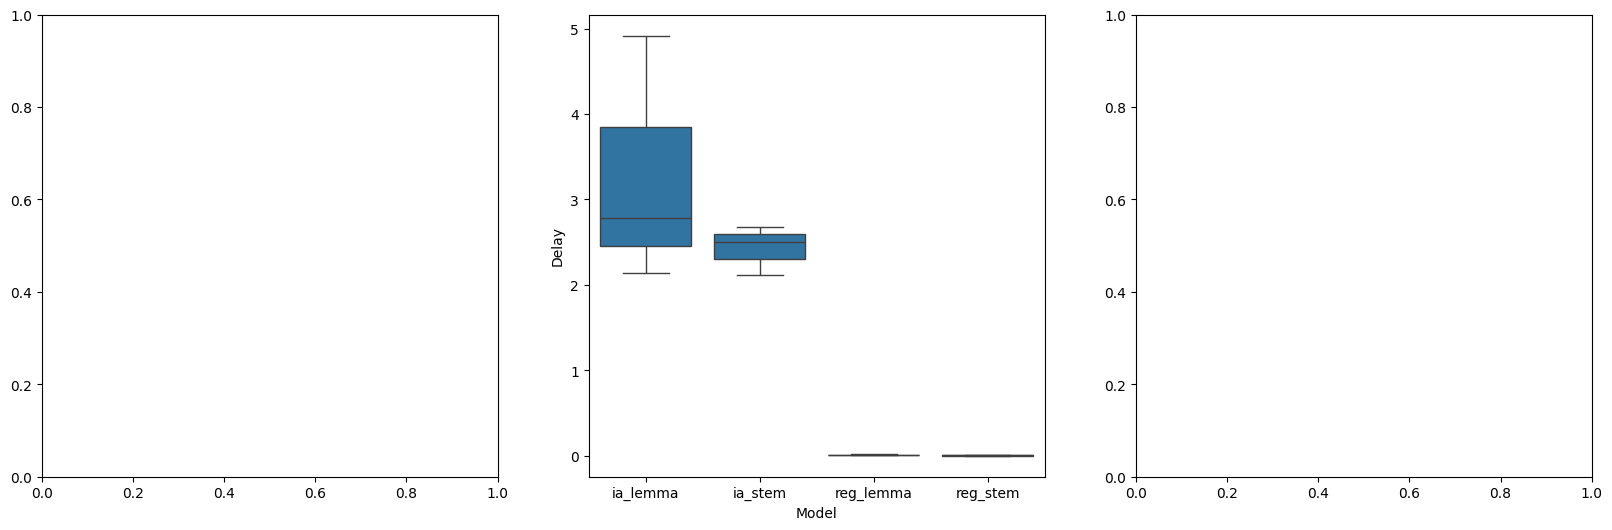

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(x="Model", y="Delay", data=df, ax=axs[1])